In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from utils import data_processing
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae

import os
import json
import optuna

/Users/vantnguy/Working/HI-VAE_ext/utils/simulations.py:46: SyntaxWarning: invalid escape sequence '\e'
  """Sparse and exponential model weights generator


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Simulate the initial data

In [2]:
# Simulation parameters
n_samples = 600
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 2.5
scale_C_indep = 3.9
feature_types_list = ["real", "cat"]
independent = True
data_types_create = True

control, treated, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                         n_features_bytype, n_active_features, p_treated, shape_T,
                                         shape_C, scale_C, scale_C_indep, data_types_create, seed=0)

control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
treated

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,-1.058193,-0.155469,-0.012403,-0.701651,-2.373270,-1.096561,0.0,1.0,0.0,0.0,0.0,0.0,0.316413,1
2,-1.368944,-1.778636,-2.213187,-1.122147,-1.284117,-2.051329,0.0,0.0,0.0,1.0,0.0,0.0,0.187360,1
3,1.128014,-0.438751,0.006500,0.644974,-0.596104,-1.422907,0.0,0.0,0.0,0.0,0.0,1.0,1.896000,1
5,0.082546,-0.595064,0.050561,1.647213,0.598506,-0.079007,0.0,0.0,1.0,1.0,1.0,1.0,1.644776,1
6,-0.672167,-1.972078,-0.997334,-1.250242,-0.961503,-0.422766,1.0,0.0,1.0,0.0,1.0,1.0,2.851355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,-0.036185,0.220181,0.696582,-0.549663,0.325955,-0.144288,0.0,1.0,1.0,0.0,1.0,0.0,0.203810,1
593,-0.701154,-0.156050,-0.669674,0.488103,1.135353,1.170932,1.0,0.0,1.0,1.0,1.0,1.0,0.569835,1
595,-0.977090,-0.211841,0.974066,0.726702,1.471096,0.803886,1.0,1.0,1.0,1.0,1.0,1.0,1.702131,1
598,0.803141,-0.949671,-0.858720,-0.451354,-0.111872,0.647917,1.0,1.0,0.0,1.0,1.0,1.0,0.959465,1


In [4]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
1,-0.620116,-0.987304,0.494666,0.166897,-1.119509,-0.210453,0.0,0.0,1.0,0.0,0.0,0.0,0.498643,1
4,0.874445,0.820363,1.377438,0.452029,0.226290,0.216713,1.0,1.0,1.0,1.0,1.0,1.0,2.070134,0
11,0.386280,0.632000,1.038750,0.349346,-0.678958,0.541789,0.0,1.0,1.0,1.0,0.0,1.0,2.516820,1
12,1.453227,0.145134,-0.593687,-1.056960,-2.069638,-2.300999,0.0,0.0,0.0,0.0,0.0,0.0,0.373784,0
14,-0.461897,-1.139139,-0.494944,0.213642,-0.509902,-1.174044,0.0,0.0,0.0,0.0,0.0,0.0,0.646194,1


In [5]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

percent of uncensored data in control set 0.840 and in treated set 0.843


## Save data

In [6]:
dataset_name = "Simulations_5_indep"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control, index=False, header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated, index=False, header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [7]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [8]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [9]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [10]:
treatment_effect_best_param = 0.
metric_optuna = "survival_km_distance"
# Parameters of the optuna study
multiplier_trial = 10 # multiplier for the number of trials
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect_best_param))

generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                "HI-VAE_piecewise" : surv_hivae,
                "Surv-GAN" : surv_gan,
                "Surv-VAE" : surv_vae}


# BEST PARAMETERS
best_params_dict = {}
for generator_name in generators_sel:
    # n_trials = min(100, int(multiplier_trial * generators_dict[generator_name].get_n_hyperparameters(generator_name)))
    n_trials = 150
    best_params_file = "./dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    with open(best_params_file, "r") as f:
        best_params_dict[generator_name] = json.load(f)

### Run models with best hyperparameters

In [11]:
best_params_hivae_weibull = best_params_dict["HI-VAE_weibull"]
best_params_hivae_piecewise = best_params_dict["HI-VAE_piecewise"]
best_params_survgan = best_params_dict["Surv-GAN"]
best_params_survae = best_params_dict["Surv-VAE"]

print("Best parameters for HI-VAE Weibull: {}".format(best_params_hivae_weibull))
print("Best parameters for HI-VAE Piecewise: {}".format(best_params_hivae_piecewise))
print("Best parameters for Surv-GAN: {}".format(best_params_survgan))
print("Best parameters for Surv-VAE: {}".format(best_params_survae))

Best parameters for HI-VAE Weibull: {'lr': 0.001, 'batch_size': 180, 'z_dim': 25, 'y_dim': 175, 's_dim': 200}
Best parameters for HI-VAE Piecewise: {'lr': 0.001, 'batch_size': 180, 'z_dim': 90, 'y_dim': 85, 's_dim': 70, 'n_layers_surv_piecewise': 1, 'n_intervals': 15}
Best parameters for Surv-GAN: {'generator_n_layers_hidden': 2, 'generator_n_units_hidden': 150, 'generator_nonlin': 'leaky_relu', 'generator_dropout': 0.19697492628909993, 'discriminator_n_layers_hidden': 4, 'discriminator_n_units_hidden': 100, 'discriminator_nonlin': 'relu', 'discriminator_dropout': 0.09853466874748673, 'lr': 0.001, 'weight_decay': 0.0001, 'encoder_max_clusters': 18}
Best parameters for Surv-VAE: {'n_iter': 100, 'lr': 0.0001, 'decoder_n_layers_hidden': 1, 'weight_decay': 0.0001, 'batch_size': 512, 'n_units_embedding': 500, 'decoder_n_units_hidden': 300, 'decoder_nonlin': 'leaky_relu', 'decoder_dropout': 0.11209256379752258, 'encoder_n_layers_hidden': 1, 'encoder_n_units_hidden': 350, 'encoder_nonlin': 'r

In [12]:
from simulation_experiment import true_univ_coef
from utils.metrics import fit_cox_model, general_metrics

Device : cpu


In [13]:
def adjust_feat_types_for_generator(generator_name, feat_types_dict):
    feat_types_dict_ext = [dict(ft) for ft in feat_types_dict]  # deep copy
    for d in feat_types_dict_ext:
        if d['name'] == "survcens":
            if generator_name == "HI-VAE_weibull":
                d["type"] = 'surv_weibull'
            elif generator_name == "HI-VAE_lognormal":
                d["type"] = 'surv'
            else:
                d["type"] = 'surv_piecewise'
    return feat_types_dict_ext

In [14]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

Monte-Carlo experiment 0
Epoch: [ 0]  time: 0.0814, ELBO_train: -14.00172615, KL_z: 0.34814140, KL_s: 0.10372448, reconstruction loss: -13.54986027
Epoch: [100]  time: 1.0739, ELBO_train: -12.65040398, KL_z: 0.85227627, KL_s: 0.02484035, reconstruction loss: -11.77328736
Epoch: [200]  time: 2.1179, ELBO_train: -12.08101368, KL_z: 1.17749798, KL_s: 0.01360846, reconstruction loss: -10.88990724
Epoch: [300]  time: 3.0965, ELBO_train: -12.03206348, KL_z: 1.34883988, KL_s: 0.01049471, reconstruction loss: -10.67272890
Epoch: [400]  time: 4.0958, ELBO_train: -12.14455795, KL_z: 1.46625233, KL_s: 0.00925446, reconstruction loss: -10.66905117
Epoch: [500]  time: 5.1163, ELBO_train: -11.68013382, KL_z: 1.58494604, KL_s: 0.00909662, reconstruction loss: -10.08609116
Epoch: [600]  time: 6.1462, ELBO_train: -11.78085136, KL_z: 1.73966408, KL_s: 0.00916481, reconstruction loss: -10.03202248
Epoch: [700]  time: 7.1042, ELBO_train: -11.86577988, KL_z: 1.86167836, KL_s: 0.00916243, reconstruction los

[2025-06-25T11:37:50.354217+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:37:51.652101+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  6%|▌         | 599/10000 [00:11<02:52, 54.40it/s]
[2025-06-25T11:38:30.770647+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:38:30.798582+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 112.63it/s]


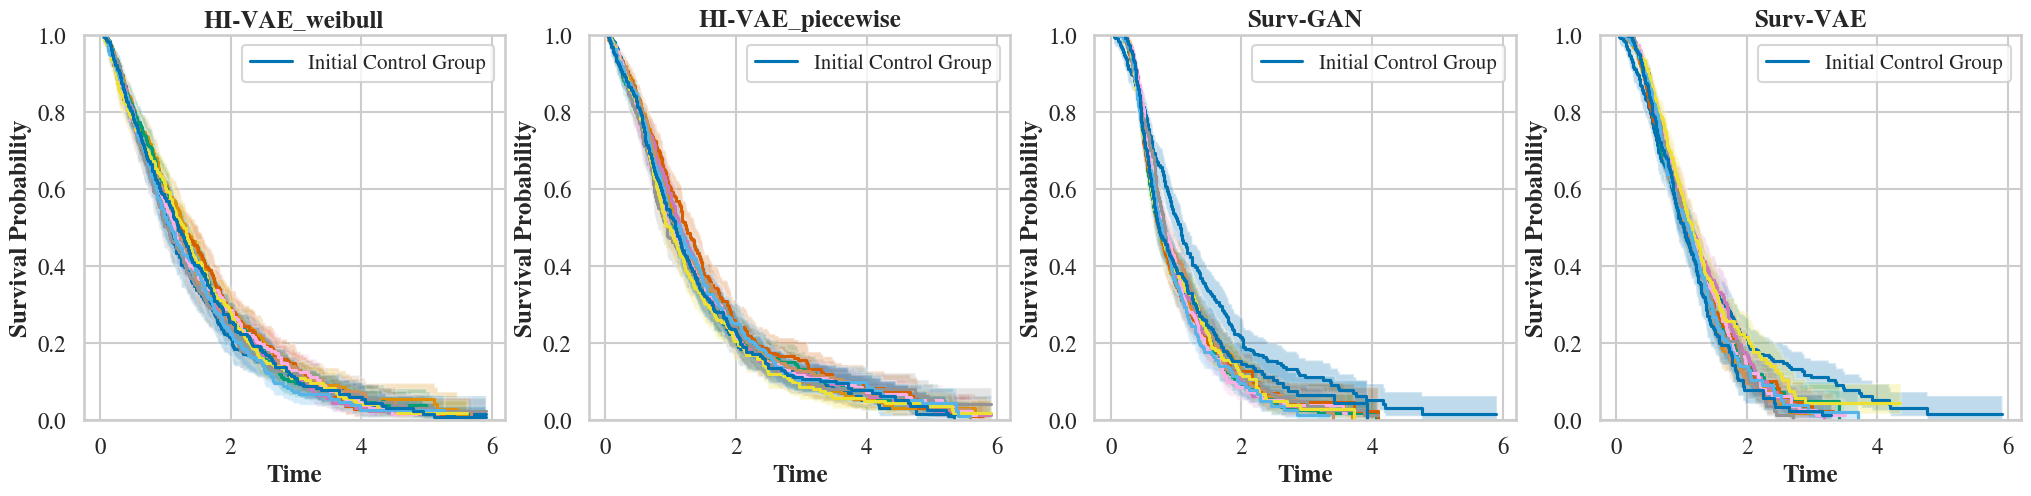

Monte-Carlo experiment 1
Epoch: [ 0]  time: 0.0222, ELBO_train: -13.85736465, KL_z: 0.36007237, KL_s: 0.10412884, reconstruction loss: -13.39316344
Epoch: [100]  time: 1.0601, ELBO_train: -12.22773457, KL_z: 0.91642272, KL_s: 0.02487516, reconstruction loss: -11.28643668
Epoch: [200]  time: 2.1158, ELBO_train: -11.60087490, KL_z: 1.14819431, KL_s: 0.01306772, reconstruction loss: -10.43961287
Epoch: [300]  time: 3.1915, ELBO_train: -11.94194221, KL_z: 1.31545007, KL_s: 0.00958920, reconstruction loss: -10.61690295
Epoch: [400]  time: 4.4057, ELBO_train: -11.71712780, KL_z: 1.37173653, KL_s: 0.00905752, reconstruction loss: -10.33633375
Epoch: [500]  time: 5.3190, ELBO_train: -11.82961178, KL_z: 1.55436492, KL_s: 0.00857401, reconstruction loss: -10.26667285
Epoch: [600]  time: 6.2283, ELBO_train: -11.25143242, KL_z: 1.74272466, KL_s: 0.00944853, reconstruction loss: -9.49925923
Epoch: [700]  time: 7.1345, ELBO_train: -11.80169773, KL_z: 1.78666210, KL_s: 0.00997400, reconstruction loss

[2025-06-25T11:39:56.639582+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:39:56.697898+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|█         | 1049/10000 [00:19<02:48, 53.04it/s]
[2025-06-25T11:40:43.771714+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:40:43.786889+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 113.44it/s]


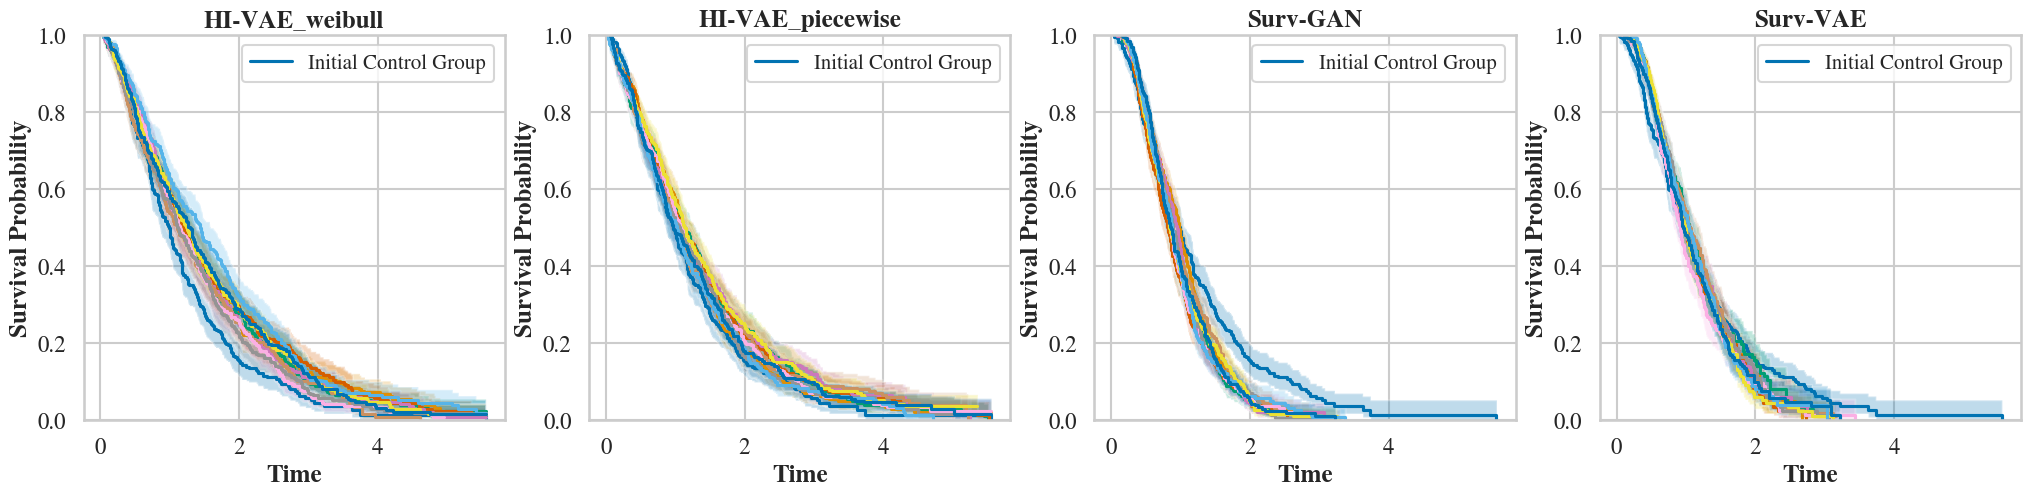

Monte-Carlo experiment 2
Epoch: [ 0]  time: 0.0103, ELBO_train: -13.81310940, KL_z: 0.34391361, KL_s: 0.10389042, reconstruction loss: -13.36530536
Epoch: [100]  time: 0.8884, ELBO_train: -12.02105618, KL_z: 0.83417052, KL_s: 0.02533627, reconstruction loss: -11.16154939
Epoch: [200]  time: 1.7507, ELBO_train: -12.18776035, KL_z: 1.09703541, KL_s: 0.01292562, reconstruction loss: -11.07779932
Epoch: [300]  time: 2.6265, ELBO_train: -11.96184921, KL_z: 1.26114881, KL_s: 0.00995827, reconstruction loss: -10.69074214
Epoch: [400]  time: 3.4990, ELBO_train: -11.71950436, KL_z: 1.32163608, KL_s: 0.00903273, reconstruction loss: -10.38883555
Epoch: [500]  time: 4.3754, ELBO_train: -11.68409824, KL_z: 1.47297180, KL_s: 0.00836325, reconstruction loss: -10.20276320
Epoch: [600]  time: 5.2504, ELBO_train: -11.97835827, KL_z: 1.59169555, KL_s: 0.00886631, reconstruction loss: -10.37779641
Epoch: [700]  time: 6.1537, ELBO_train: -11.52308369, KL_z: 1.70062411, KL_s: 0.00860167, reconstruction los

[2025-06-25T11:42:23.032625+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:42:23.086772+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|▉         | 999/10000 [00:18<02:47, 53.63it/s]
[2025-06-25T11:43:09.255228+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:43:09.271448+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 132.17it/s]


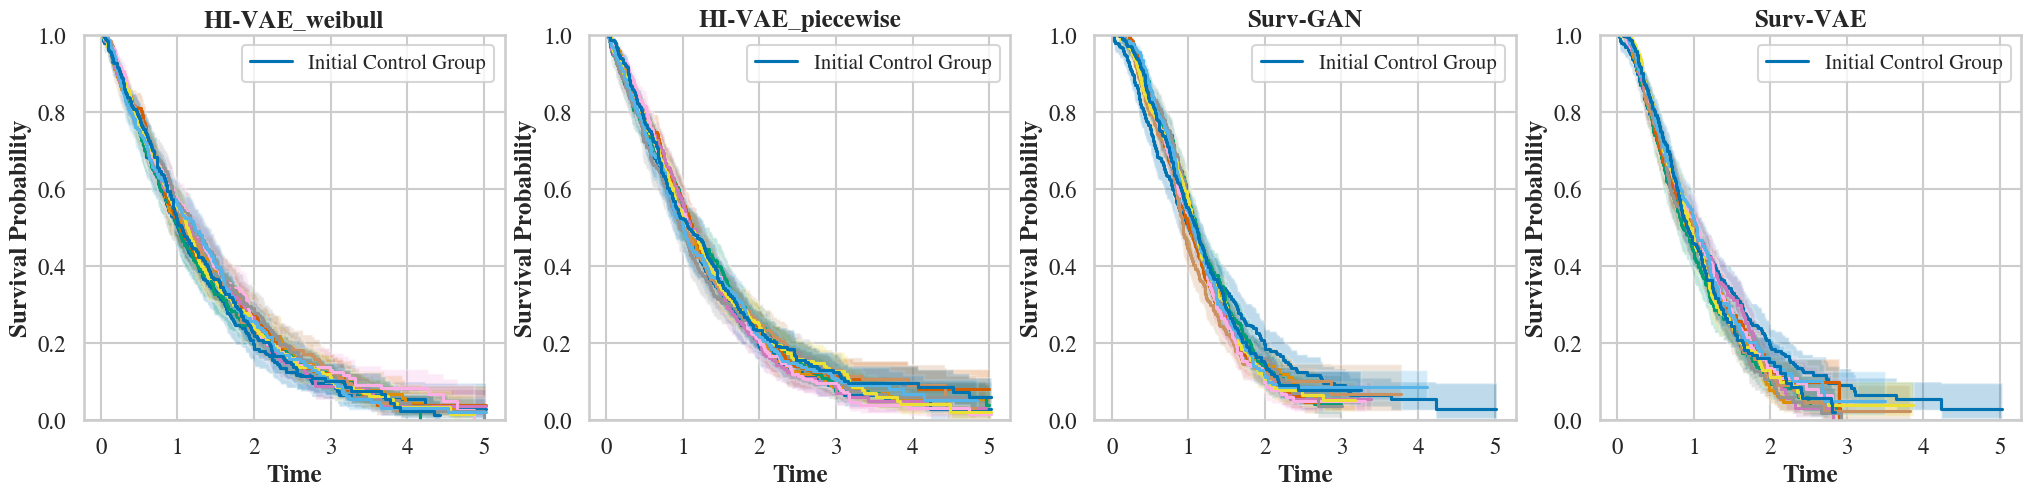

Monte-Carlo experiment 3
Epoch: [ 0]  time: 0.0335, ELBO_train: -14.14406586, KL_z: 0.35581079, KL_s: 0.10329247, reconstruction loss: -13.68496260
Epoch: [100]  time: 1.0545, ELBO_train: -12.72781181, KL_z: 0.90384030, KL_s: 0.02462482, reconstruction loss: -11.79934669
Epoch: [200]  time: 2.5020, ELBO_train: -12.23947048, KL_z: 1.15376341, KL_s: 0.01268625, reconstruction loss: -11.07302082
Epoch: [300]  time: 4.1124, ELBO_train: -11.90275574, KL_z: 1.31780982, KL_s: 0.00954580, reconstruction loss: -10.57540011
Epoch: [400]  time: 5.2141, ELBO_train: -12.12061214, KL_z: 1.45145750, KL_s: 0.00898790, reconstruction loss: -10.66016674
Epoch: [500]  time: 6.2174, ELBO_train: -11.28620148, KL_z: 1.59355712, KL_s: 0.00860310, reconstruction loss: -9.68404126
Epoch: [600]  time: 7.1763, ELBO_train: -11.65053272, KL_z: 1.73868167, KL_s: 0.00853014, reconstruction loss: -9.90332091
Epoch: [700]  time: 8.0841, ELBO_train: -11.54257298, KL_z: 1.78912759, KL_s: 0.00920773, reconstruction loss:

[2025-06-25T11:44:37.290868+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:44:37.343979+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|▋         | 749/10000 [00:15<03:09, 48.88it/s]
[2025-06-25T11:45:20.375825+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:45:20.391893+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 120.63it/s]


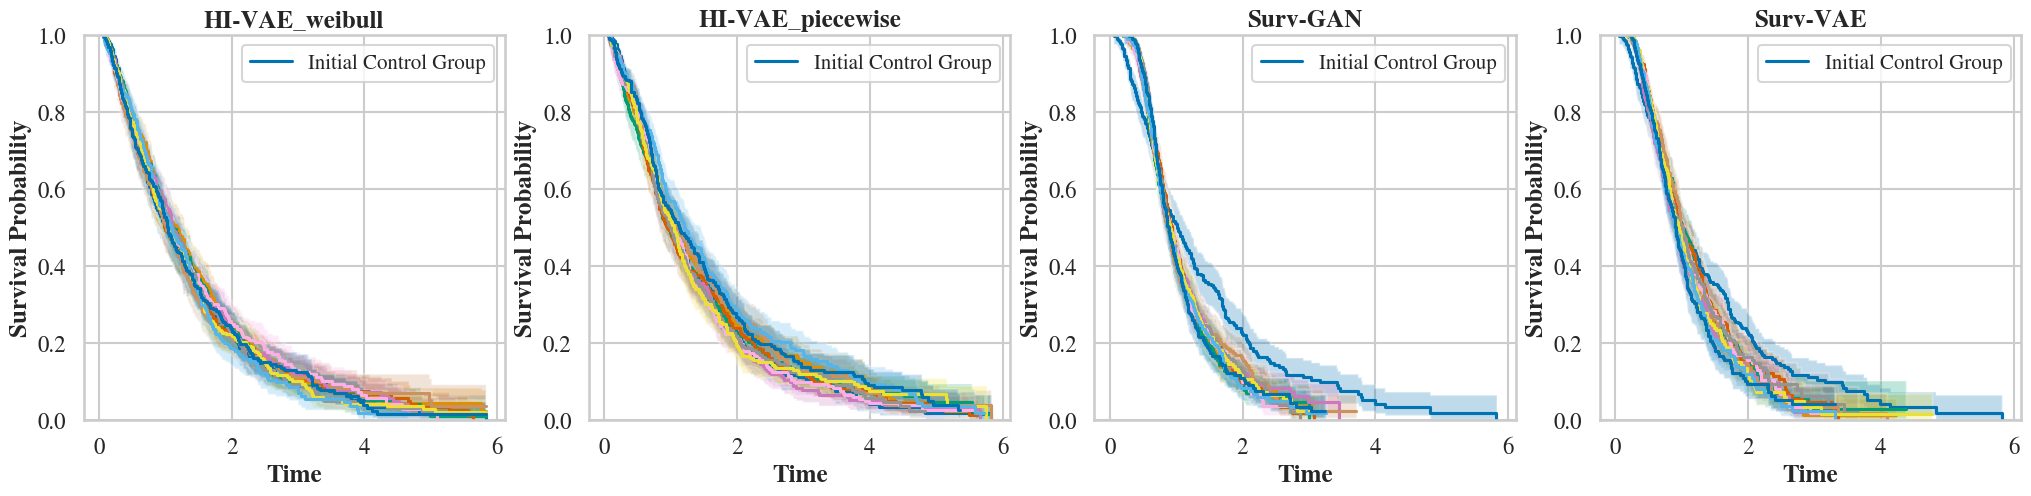

Monte-Carlo experiment 4
Epoch: [ 0]  time: 0.0381, ELBO_train: -13.89149475, KL_z: 0.37018374, KL_s: 0.10374975, reconstruction loss: -13.41756126
Epoch: [100]  time: 1.1070, ELBO_train: -11.96436119, KL_z: 0.94407248, KL_s: 0.02440262, reconstruction loss: -10.99588609
Epoch: [200]  time: 2.2919, ELBO_train: -12.11200237, KL_z: 1.19906461, KL_s: 0.01265049, reconstruction loss: -10.90028727
Epoch: [300]  time: 3.3955, ELBO_train: -12.09366035, KL_z: 1.36185884, KL_s: 0.01004887, reconstruction loss: -10.72175264
Epoch: [400]  time: 4.5176, ELBO_train: -11.67586231, KL_z: 1.50742269, KL_s: 0.00920153, reconstruction loss: -10.15923810
Epoch: [500]  time: 5.5748, ELBO_train: -11.96191311, KL_z: 1.72182453, KL_s: 0.00931931, reconstruction loss: -10.23076928
Epoch: [600]  time: 6.6531, ELBO_train: -11.78143597, KL_z: 1.76455057, KL_s: 0.00910378, reconstruction loss: -10.00778162
Epoch: [700]  time: 7.6714, ELBO_train: -11.26992989, KL_z: 1.80609179, KL_s: 0.00837278, reconstruction los

[2025-06-25T11:46:47.432274+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:46:47.496324+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|▉         | 899/10000 [00:17<03:02, 50.00it/s]
[2025-06-25T11:47:33.680726+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:47:33.696151+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 124.43it/s]


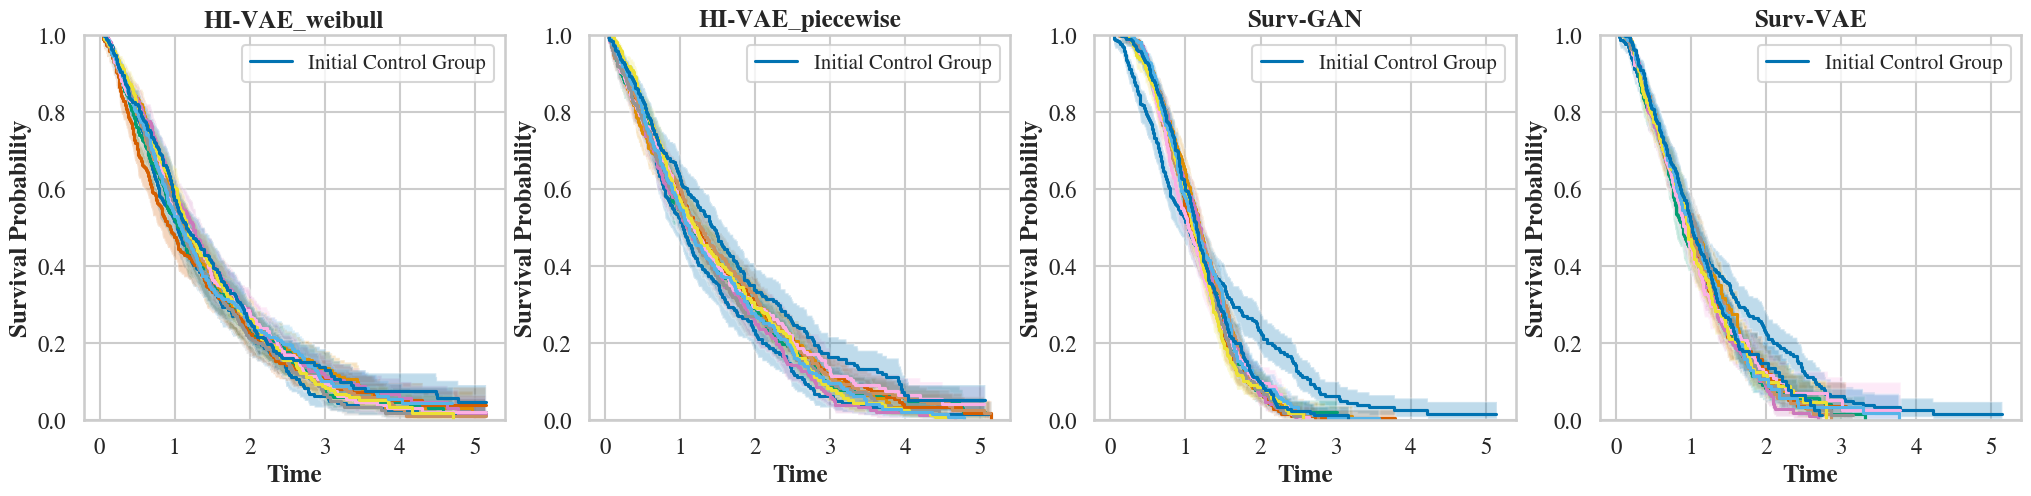

Monte-Carlo experiment 5
Epoch: [ 0]  time: 0.0188, ELBO_train: -13.35052872, KL_z: 0.35516933, KL_s: 0.10271549, reconstruction loss: -12.89264390
Epoch: [100]  time: 0.9634, ELBO_train: -12.21138096, KL_z: 0.87490946, KL_s: 0.02456713, reconstruction loss: -11.31190437
Epoch: [200]  time: 1.9437, ELBO_train: -11.40838337, KL_z: 1.22897005, KL_s: 0.01307011, reconstruction loss: -10.16634321
Epoch: [300]  time: 3.0715, ELBO_train: -11.11169910, KL_z: 1.38612115, KL_s: 0.01030779, reconstruction loss: -9.71527016
Epoch: [400]  time: 4.6433, ELBO_train: -10.95394325, KL_z: 1.51198030, KL_s: 0.00920677, reconstruction loss: -9.43275619
Epoch: [500]  time: 6.0618, ELBO_train: -10.89311123, KL_z: 1.64292705, KL_s: 0.00882959, reconstruction loss: -9.24135458
Epoch: [600]  time: 7.4282, ELBO_train: -11.36532879, KL_z: 1.78263295, KL_s: 0.00938654, reconstruction loss: -9.57330930
Epoch: [700]  time: 8.6386, ELBO_train: -10.92913055, KL_z: 1.88160944, KL_s: 0.00916910, reconstruction loss: -

[2025-06-25T11:50:06.153153+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:50:06.202134+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|█         | 1049/10000 [00:25<03:35, 41.52it/s]
[2025-06-25T11:51:02.163105+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:51:02.186305+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:01<00:00, 71.46it/s]


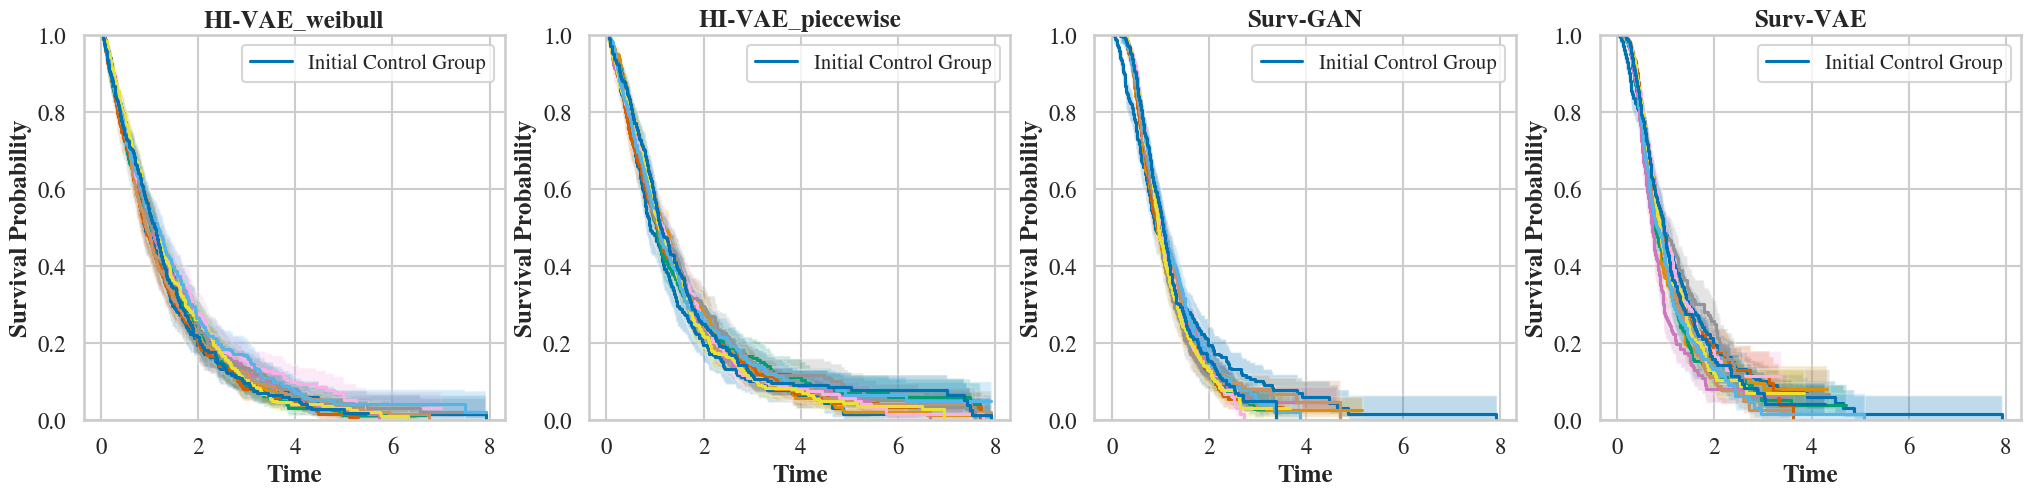

Monte-Carlo experiment 6
Epoch: [ 0]  time: 0.0250, ELBO_train: -13.88483238, KL_z: 0.35633245, KL_s: 0.10348511, reconstruction loss: -13.42501482
Epoch: [100]  time: 0.9620, ELBO_train: -12.16154003, KL_z: 0.90563786, KL_s: 0.02514935, reconstruction loss: -11.23075283
Epoch: [200]  time: 1.8773, ELBO_train: -11.69072151, KL_z: 1.20146418, KL_s: 0.01246691, reconstruction loss: -10.47679043
Epoch: [300]  time: 2.7920, ELBO_train: -11.95853424, KL_z: 1.37300766, KL_s: 0.00937653, reconstruction loss: -10.57615006
Epoch: [400]  time: 3.7369, ELBO_train: -12.14564228, KL_z: 1.46120405, KL_s: 0.00834703, reconstruction loss: -10.67609119
Epoch: [500]  time: 4.7053, ELBO_train: -11.62857246, KL_z: 1.62418163, KL_s: 0.00806141, reconstruction loss: -9.99632943
Epoch: [600]  time: 5.6919, ELBO_train: -11.36388683, KL_z: 1.65789068, KL_s: 0.00819445, reconstruction loss: -9.69780171
Epoch: [700]  time: 6.6501, ELBO_train: -11.38757896, KL_z: 1.78077900, KL_s: 0.00795746, reconstruction loss:

[2025-06-25T11:53:48.080620+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:53:48.146446+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|▊         | 849/10000 [00:22<04:01, 37.83it/s]
[2025-06-25T11:54:43.227833+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:54:43.246245+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:01<00:00, 73.10it/s]


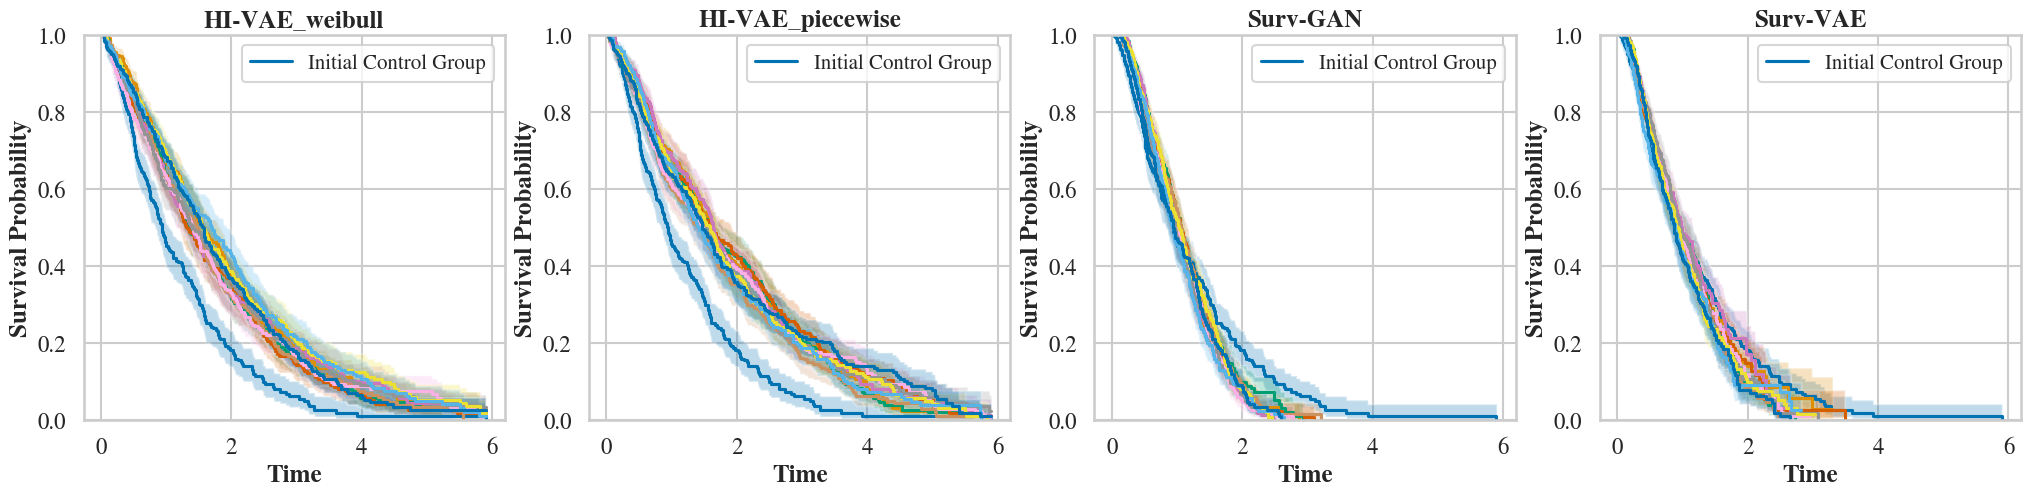

Monte-Carlo experiment 7
Epoch: [ 0]  time: 0.0375, ELBO_train: -13.95123291, KL_z: 0.35453156, KL_s: 0.10321665, reconstruction loss: -13.49348471
Epoch: [100]  time: 0.9801, ELBO_train: -12.19747734, KL_z: 0.91279238, KL_s: 0.02518177, reconstruction loss: -11.25950319
Epoch: [200]  time: 2.0985, ELBO_train: -12.06043148, KL_z: 1.21844375, KL_s: 0.01163197, reconstruction loss: -10.83035576
Epoch: [300]  time: 3.1490, ELBO_train: -12.48345375, KL_z: 1.42978621, KL_s: 0.00858212, reconstruction loss: -11.04508543
Epoch: [400]  time: 4.2516, ELBO_train: -11.58542061, KL_z: 1.51836550, KL_s: 0.00751019, reconstruction loss: -10.05954492
Epoch: [500]  time: 5.4765, ELBO_train: -12.04909706, KL_z: 1.67106903, KL_s: 0.00756788, reconstruction loss: -10.37046015
Epoch: [600]  time: 6.5893, ELBO_train: -11.30627823, KL_z: 1.81313527, KL_s: 0.00717497, reconstruction loss: -9.48596799
Epoch: [700]  time: 7.6837, ELBO_train: -11.13247204, KL_z: 1.90041101, KL_s: 0.00728607, reconstruction loss

[2025-06-25T11:57:35.916213+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:57:35.995047+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|▉         | 949/10000 [00:24<03:53, 38.81it/s]
[2025-06-25T11:58:31.982809+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T11:58:32.001070+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:01<00:00, 88.15it/s]


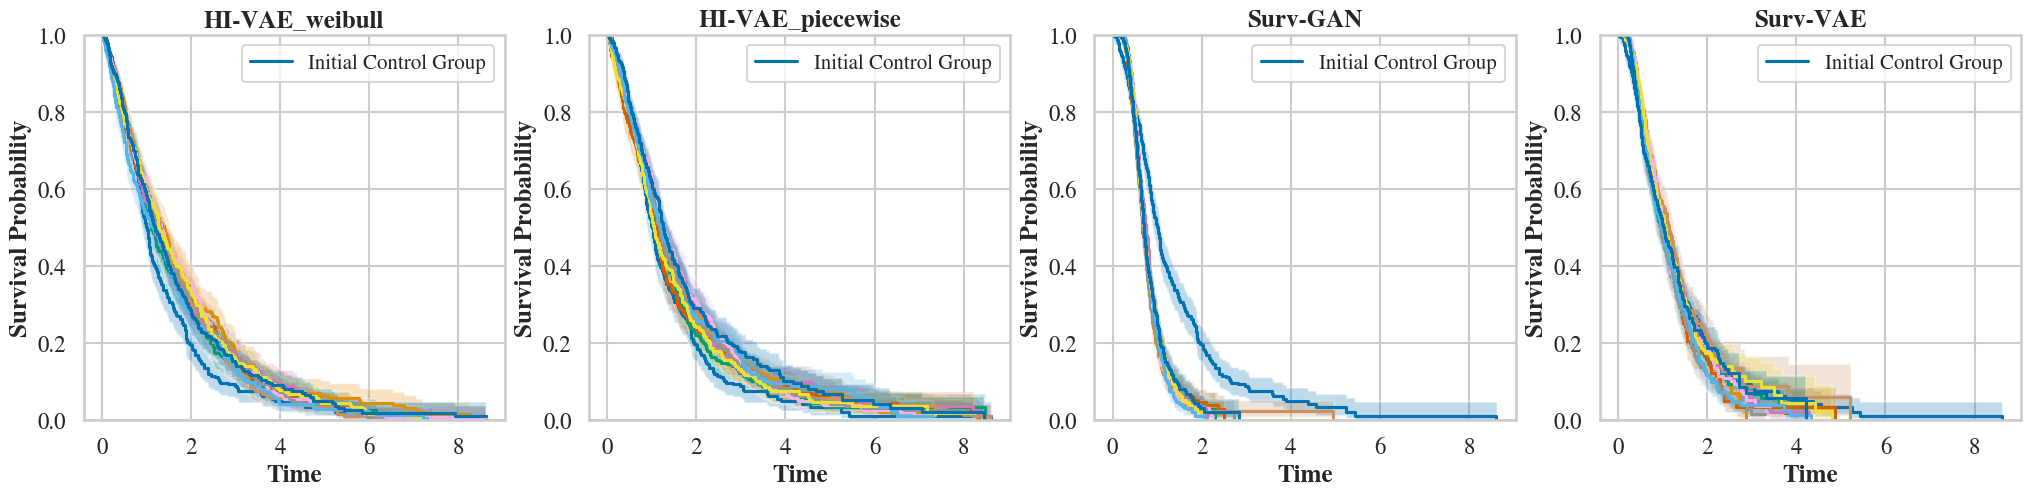

Monte-Carlo experiment 8
Epoch: [ 0]  time: 0.1165, ELBO_train: -13.52179241, KL_z: 0.35692385, KL_s: 0.10388613, reconstruction loss: -13.06098244
Epoch: [100]  time: 5.1694, ELBO_train: -12.07885170, KL_z: 0.79376918, KL_s: 0.02546740, reconstruction loss: -11.25961512
Epoch: [200]  time: 8.2462, ELBO_train: -12.05035496, KL_z: 1.17860401, KL_s: 0.01284456, reconstruction loss: -10.85890639
Epoch: [300]  time: 12.5213, ELBO_train: -11.93394947, KL_z: 1.28793347, KL_s: 0.01006651, reconstruction loss: -10.63594949
Epoch: [400]  time: 18.6657, ELBO_train: -11.76251507, KL_z: 1.40009069, KL_s: 0.00934601, reconstruction loss: -10.35307837
Epoch: [500]  time: 22.5369, ELBO_train: -11.18875694, KL_z: 1.52957761, KL_s: 0.00937653, reconstruction loss: -9.64980280
Epoch: [600]  time: 25.8277, ELBO_train: -11.28154945, KL_z: 1.71539676, KL_s: 0.00915575, reconstruction loss: -9.55699694
Epoch: [700]  time: 28.2182, ELBO_train: -11.64023876, KL_z: 1.81214392, KL_s: 0.00933599, reconstruction 

[2025-06-25T12:01:52.235323+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T12:01:52.312027+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|▍         | 399/10000 [00:09<03:52, 41.34it/s]
[2025-06-25T12:02:31.819053+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T12:02:31.831888+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 101.53it/s]


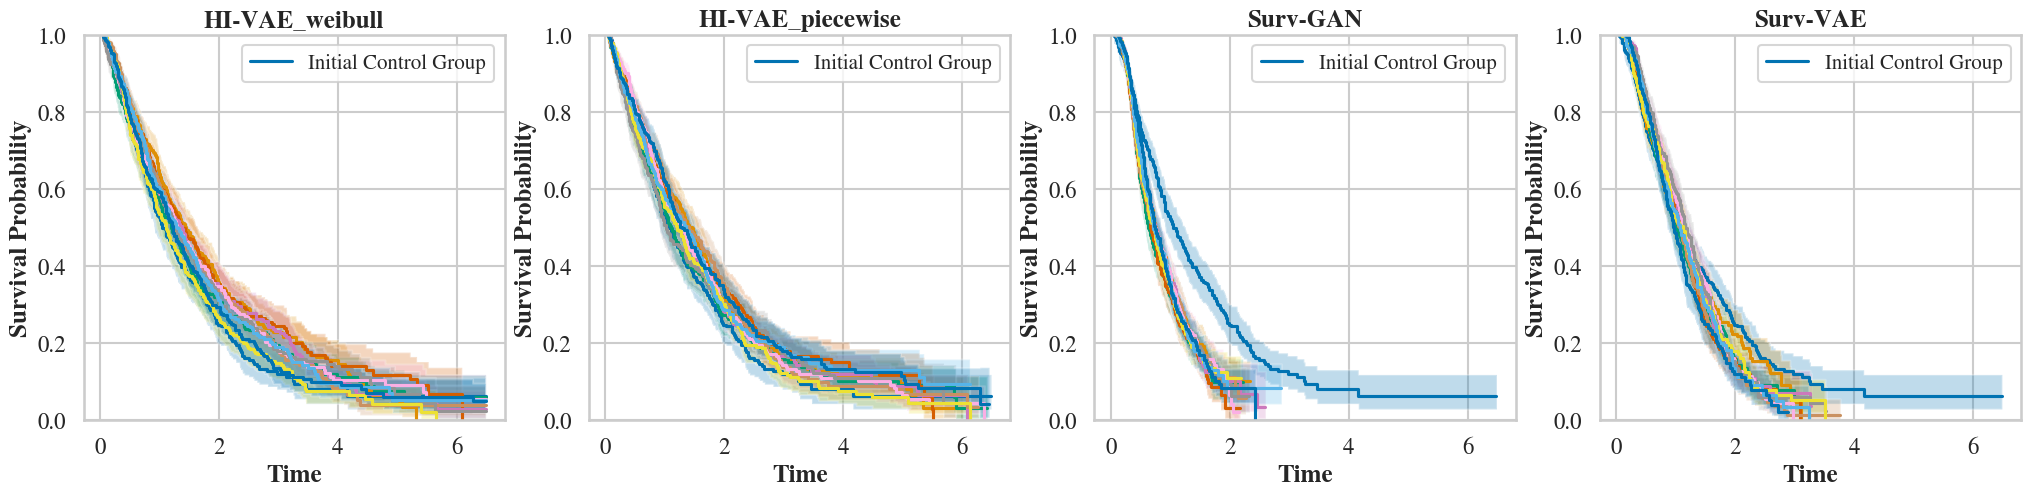

Monte-Carlo experiment 9
Epoch: [ 0]  time: 0.0810, ELBO_train: -13.84414291, KL_z: 0.35111147, KL_s: 0.10445786, reconstruction loss: -13.38857359
Epoch: [100]  time: 1.0880, ELBO_train: -12.30311680, KL_z: 0.82240921, KL_s: 0.02517414, reconstruction loss: -11.45553344
Epoch: [200]  time: 2.2137, ELBO_train: -11.95817184, KL_z: 1.09239244, KL_s: 0.01211262, reconstruction loss: -10.85366678
Epoch: [300]  time: 3.3167, ELBO_train: -12.14719486, KL_z: 1.20307195, KL_s: 0.00916386, reconstruction loss: -10.93495905
Epoch: [400]  time: 4.9242, ELBO_train: -11.99512291, KL_z: 1.40066159, KL_s: 0.00777435, reconstruction loss: -10.58668697
Epoch: [500]  time: 6.0304, ELBO_train: -11.69520950, KL_z: 1.52554393, KL_s: 0.00765181, reconstruction loss: -10.16201377
Epoch: [600]  time: 7.2484, ELBO_train: -11.50814915, KL_z: 1.63646710, KL_s: 0.00774622, reconstruction loss: -9.86393583
Epoch: [700]  time: 8.4443, ELBO_train: -11.72452164, KL_z: 1.70230949, KL_s: 0.00795031, reconstruction loss

[2025-06-25T12:05:31.887717+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T12:05:31.970410+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|▊         | 849/10000 [00:18<03:16, 46.52it/s]
[2025-06-25T12:06:19.606044+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T12:06:19.623818+0200][55188][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 100/100 [00:00<00:00, 111.14it/s]


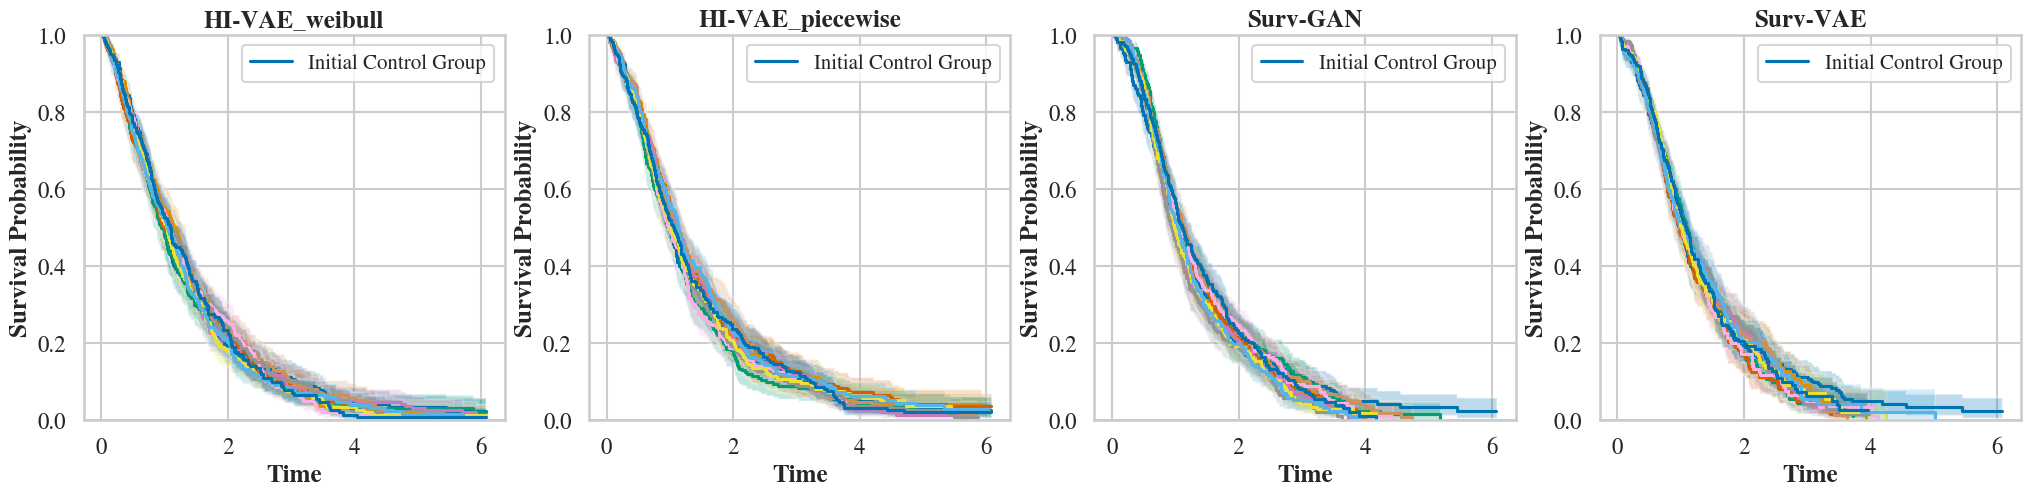

In [15]:
# MONTE-CARLO EXPERIMENT
n_MC_exp = 10
treat_effects = np.arange(0., 1.1, 0.2)
epochs = 10000

synthcity_metrics_sel = ['J-S distance', 'KS test', 'Survival curves distance',
                            'Detection XGB', 'NNDR', 'K-map score']

# Initialize storage for metrics and results
synthcity_metrics_res_dict = {generator_name: pd.DataFrame() for generator_name in generators_sel}
log_p_value_gen_dict = {generator_name: [] for generator_name in generators_sel}
log_p_value_control_dict = {generator_name: [] for generator_name in generators_sel}
est_cox_coef_gen_dict = {generator_name: [] for generator_name in generators_sel}
est_cox_coef_se_gen_dict = {generator_name: [] for generator_name in generators_sel}

# Initialize result variables for MC experiment
simu_num = []
D_control = []
D_treated = []
coef_init_univ_list = []
H0_coef = []
log_p_value_init = []
est_cox_coef_init = []
est_cox_coef_se_init = []

# Perform Monte Carlo experiment
seed = 0
for m in np.arange(n_MC_exp):
    if m % 1 == 0:
        print(f"Monte-Carlo experiment {m}")

    # To make sure the difference between simulated datasets, increase seed value each time
    seed += 1
    # Simulate control group data
    treatment_effect = 0.0
    control, _, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                    n_features_bytype, n_active_features, p_treated, shape_T,
                                    shape_C, scale_C, scale_C_indep, data_types_create, seed=seed)
    control = control.drop(columns='treatment')

    data_file_control = os.path.join(f"./dataset/{dataset_name}", "data_control.csv")
    feat_types_file_control = os.path.join(f"./dataset/{dataset_name}", "data_types_control.csv")
    control.to_csv(data_file_control, index=False, header=False)
    types.to_csv(feat_types_file_control, index=False)

    # Load and process control data
    df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(
        data_file_control, feat_types_file_control, miss_file="Missing.csv", true_miss_file=None)
    data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
    data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

    # Format control data into DataFrame
    df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
    df_init_control["treatment"] = 0

    df_gen_control_dict ={}
    # For each generator, perform the data generation with the best and default params
    for generator_name in generators_sel:
        best_params = best_params_dict[generator_name]
        if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise", "HI-VAE_lognormal"]:
            feat_types_dict_ext = adjust_feat_types_for_generator(generator_name, feat_types_dict)
            data_gen_control = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control,
                                                                    true_miss_mask_control, feat_types_dict_ext,
                                                                    n_generated_dataset, params=best_params,
                                                                    epochs=epochs)
        else:
            data_gen_control = generators_dict[generator_name].run(data_init_control, columns=fnames,
                                                                    target_column="censor", time_to_event_column="time",
                                                                    n_generated_dataset=n_generated_dataset,
                                                                    params=best_params)

        list_df_gen_control = []
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control["treatment"] = 0
            list_df_gen_control.append(df_gen_control)
        df_gen_control_dict[generator_name] = list_df_gen_control
        
        # Save generated data and compute metrics
        synthcity_metrics_res = general_metrics(df_init_control, list_df_gen_control, generator_name)[synthcity_metrics_sel]
        synthcity_metrics_res_ext = pd.concat([synthcity_metrics_res] * len(treat_effects))
        synthcity_metrics_res_dict[generator_name] = pd.concat([synthcity_metrics_res_dict[generator_name], 
                                                                synthcity_metrics_res_ext])

    # Compare the performance of generation in terms of p-values between generated control and treated group
    for t, treatment_effect in enumerate(treat_effects):

        coef_init_univ = true_univ_coef(treatment_effect, independent, feature_types_list,
                                        n_features_bytype, n_active_features, p_treated, shape_T,
                                        shape_C, scale_C, scale_C_indep, data_types_create, seed=seed)

        control, treated, _ = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                    n_features_bytype, n_active_features, p_treated, shape_T,
                                    shape_C, scale_C, scale_C_indep, data_types_create, seed=seed)
        treated = treated.drop(columns='treatment')

        data_file_treated = os.path.join(f"./dataset/{dataset_name}", "data_treated.csv")
        feat_types_file_treated = os.path.join(f"./dataset/{dataset_name}", "data_types_treated.csv")
        treated.to_csv(data_file_treated, index=False, header=False)
        types.to_csv(feat_types_file_treated, index=False)

        # Load and process treated data
        df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                        miss_file="Missing.csv", true_miss_file=None)
        data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_treated["treatment"] = 1

        # Combine control and treated data
        df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)
        columns = ['time', 'censor', 'treatment']
        coef_init, _, _, se_init = fit_cox_model(df_init, columns)
        est_cox_coef_init += [coef_init[0]] * n_generated_dataset
        est_cox_coef_se_init += [se_init[0]] * n_generated_dataset

        # Compute log-rank test p-value for initial control group vs initial treated group
        p_value_init = compute_logrank_test(df_init_control, df_init_treated)
        log_p_value_init += [p_value_init] * n_generated_dataset
        H0_coef += [treatment_effect] * n_generated_dataset
        simu_num += [m * len(treat_effects) + t] * n_generated_dataset
        D_control += [control['censor'].sum()] * n_generated_dataset
        D_treated += [treated['censor'].sum()] * n_generated_dataset
        coef_init_univ_list += [coef_init_univ] * n_generated_dataset

        # For each generator, compute the log-rank test p-values and Cox coefficients for generated control group vs initial treated group
        for generator_name in generators_sel:
            log_p_value_gen_list = []
            log_p_value_control_list = []
            est_cox_coef_gen = []
            est_cox_coef_se_gen = []
            for i in range(n_generated_dataset):
                df_gen_control = df_gen_control_dict[generator_name][i]
                log_p_value_gen_list.append(compute_logrank_test(df_gen_control, treated))
                log_p_value_control_list.append(compute_logrank_test(df_gen_control, control))
                df_gen = pd.concat([df_gen_control, df_init_treated], ignore_index=True)
                coef_gen, _, _, se_gen = fit_cox_model(df_gen, columns)
                est_cox_coef_gen.append(coef_gen[0])
                est_cox_coef_se_gen.append(se_gen[0])

            log_p_value_gen_dict[generator_name] += log_p_value_gen_list
            log_p_value_control_dict[generator_name] += log_p_value_control_list
            est_cox_coef_gen_dict[generator_name] += est_cox_coef_gen
            est_cox_coef_se_gen_dict[generator_name] += est_cox_coef_se_gen

    fig, axs = plt.subplots(1, len(generators_sel), figsize=(25, 5))
    for i, generator_name in enumerate(generators_sel):
        kaplan_meier_estimation(df_init_control, label="Initial Control Group", ax=axs[i])
        for j in range(10):
            compute_logrank_test(df_gen_control_dict[generator_name][j], treated)
            df_syn_sel = pd.DataFrame(df_gen_control_dict[generator_name][j], columns=fnames)
            kaplan_meier_estimation(df_syn_sel, label="", ax=axs[i])

        axs[i].set_ylim(0, 1)
        axs[i].legend(fontsize=15)
        axs[i].set_xlabel("Time", fontweight="semibold")
        axs[i].set_ylabel("Survival Probability", fontweight="semibold")
        axs[i].set_title(generator_name, fontweight="bold")
    plt.show()

# Save the results
results = pd.DataFrame({'XP_num': simu_num, 'D_control': D_control, 'D_treated': D_treated,
                        'H0_coef_univ': coef_init_univ_list, 'H0_coef': H0_coef,
                        'log_pvalue_init': log_p_value_init, 'est_cox_coef_init': est_cox_coef_init,
                        'est_cox_coef_se_init': est_cox_coef_se_init})

for generator_name in generators_sel:
    results[f"log_pvalue_{generator_name}"] = log_p_value_gen_dict[generator_name]
    results[f"log_pvalue_control_{generator_name}"] = log_p_value_control_dict[generator_name]
    results[f"est_cox_coef_{generator_name}"] = est_cox_coef_gen_dict[generator_name]
    results[f"est_cox_coef_se_{generator_name}"] = est_cox_coef_se_gen_dict[generator_name]
    for metric in synthcity_metrics_sel:
        results[f"{metric}_{generator_name}"] = synthcity_metrics_res_dict[generator_name][metric].values


In [16]:
results.to_csv(f"./dataset/{dataset_name}/results_{metric_optuna}_n_samples_{n_samples}_n_features_bytype_{n_features_bytype}.csv")

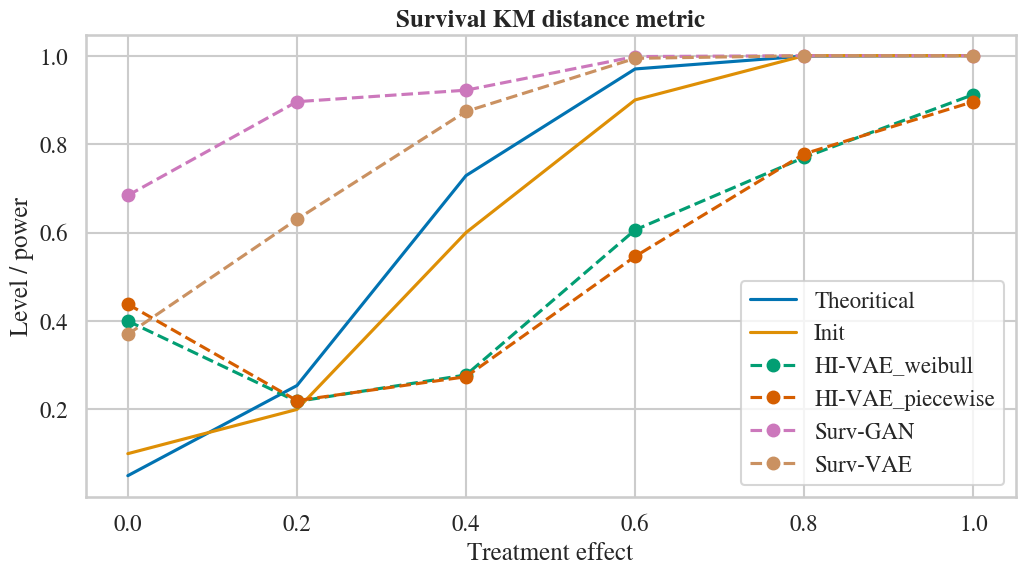

In [17]:
results_kmdist_ext = results
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
for i, generator_name in enumerate(generators_sel):
    results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()

In [18]:
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

def visualize_synthcity_metric_res(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results.shape[0], 
                                                            results[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

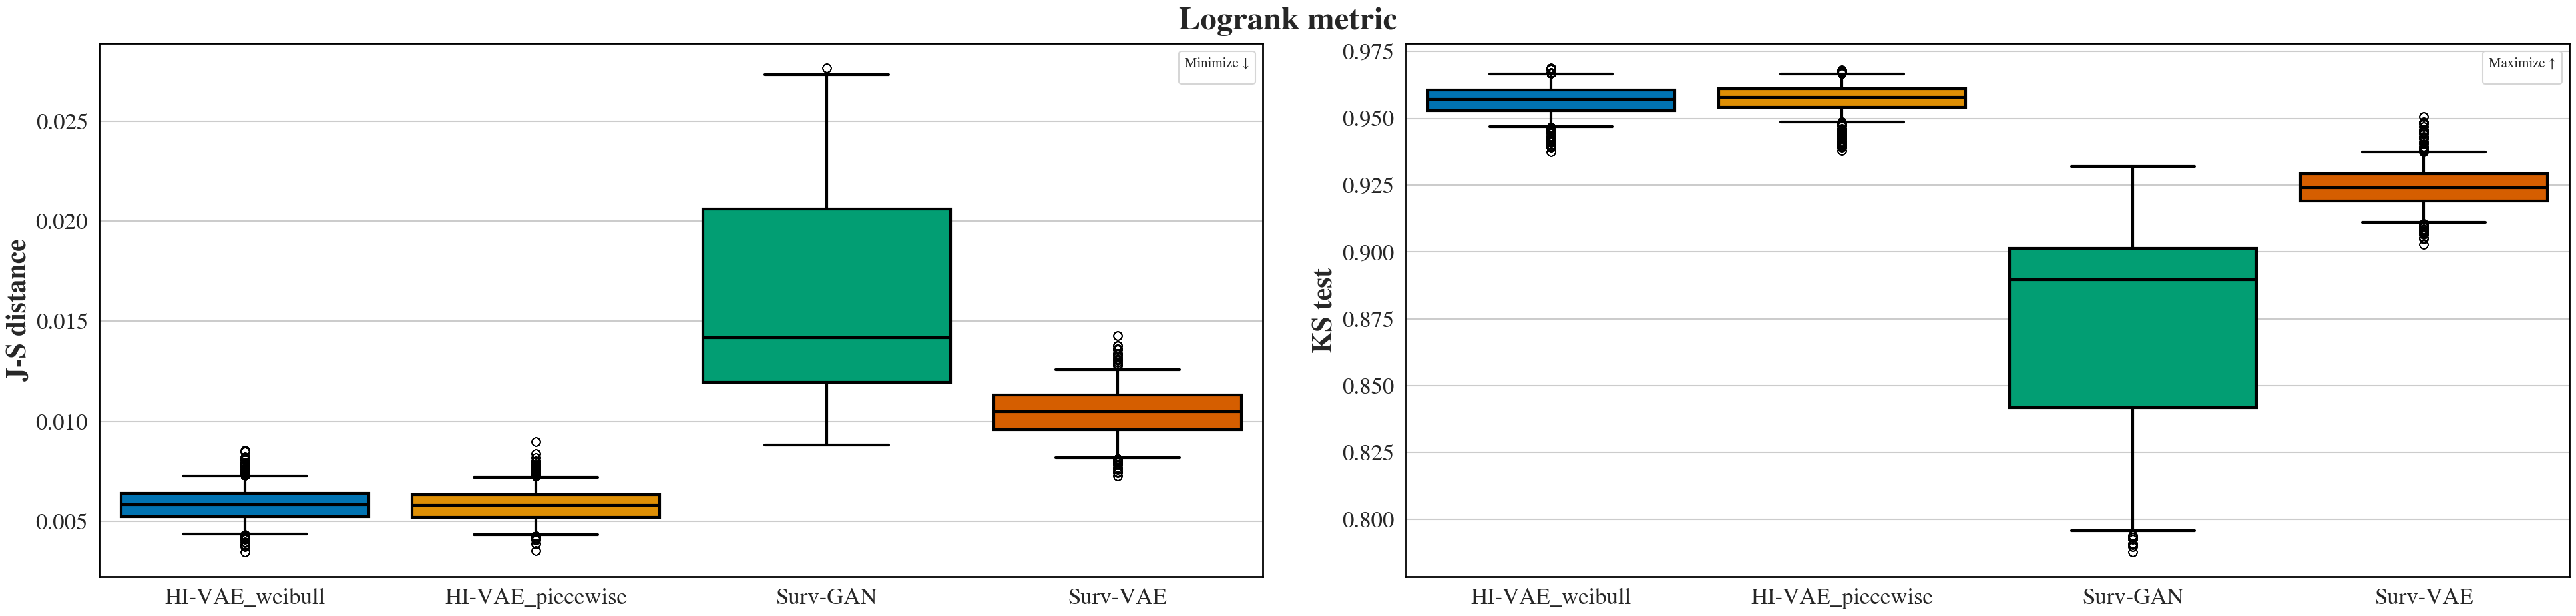

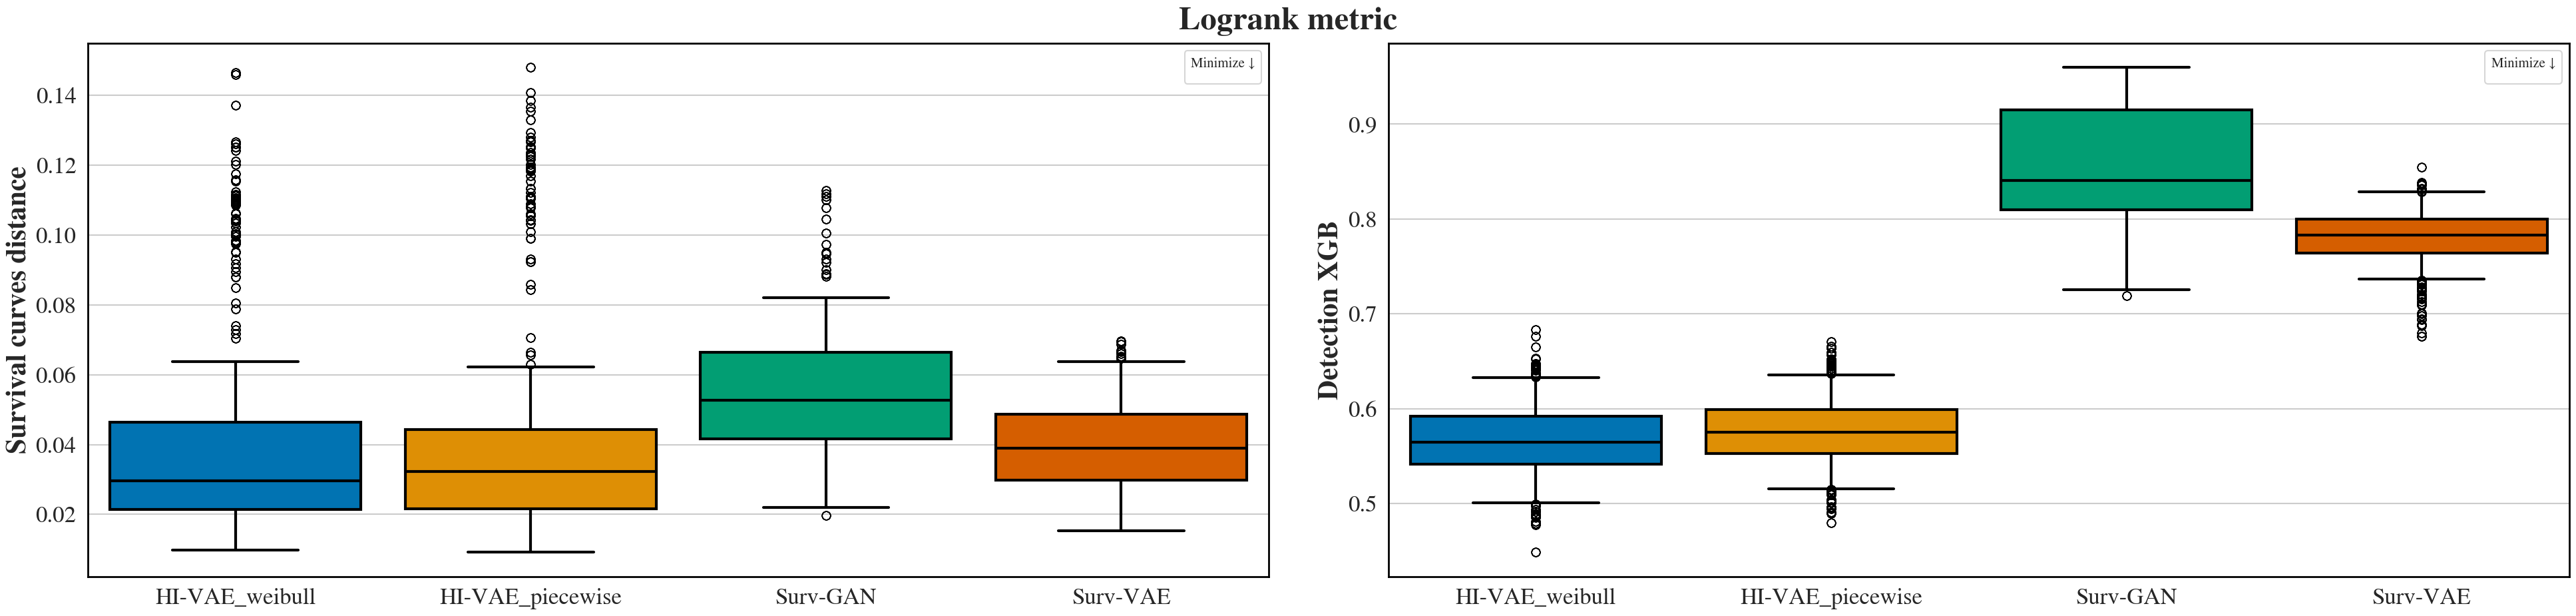

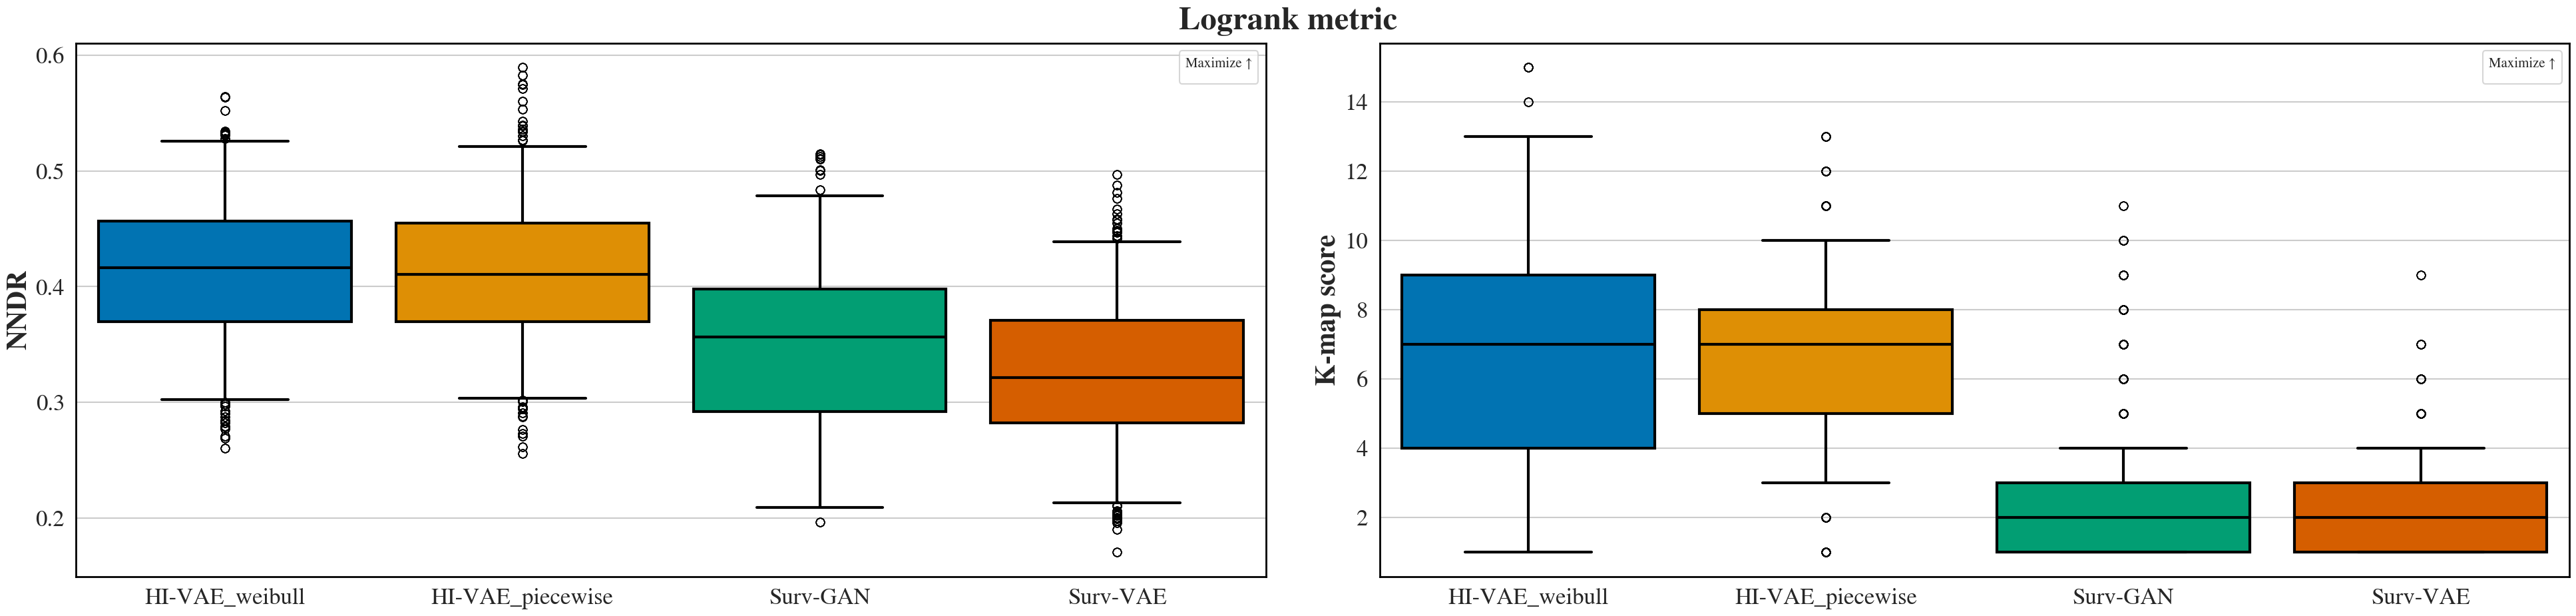

In [19]:
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res(results_kmdist_ext, metrics, 'Logrank metric')

In [20]:
metric_control_df = pd.DataFrame()
for generator_name in generators_sel:
    metric_control_df = pd.concat([metric_control_df, pd.DataFrame(np.array([[generator_name] * results_kmdist_ext.shape[0], 
                                                            results_kmdist_ext["log_pvalue_control_" + generator_name]]).T,
                                                            columns=['generator', 'log_pvalue'])])

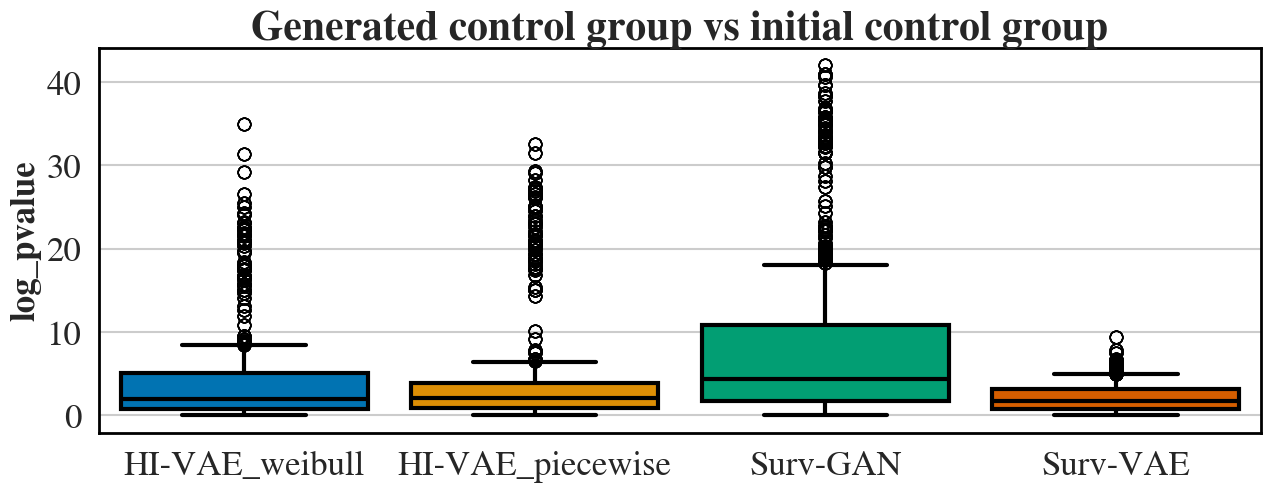

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

metric_control_df['log_pvalue'] = np.float64(metric_control_df['log_pvalue'].values)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

sns.boxplot(data=metric_control_df, x='generator', y='log_pvalue', ax=ax,
            linewidth = 3, saturation = 1, palette = 'colorblind', 
            width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
ax.set_xlabel('')
ax.set_ylabel('log_pvalue', fontsize=25, fontweight="semibold")
ax.set_title('Generated control group vs initial control group', fontsize=30, fontweight="semibold")
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)